# Proyecto UT5:
## Predicción del tipo de un pokémon a partir de su imagen

### Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as kr

import os
import shutil

### Data

Primero preparamos los pokemon con sus tipos.

Podemos observar que el dataframe incluye:
* __Name__: El nombre del pokemon.
* __Type1__: El tipo principal del pokemon.
* __Type2__: El tipo secundario del pokemon. En principio no lo utilizaremos para nada para simplificar un poco las cosas.

In [20]:
dataframe = pd.read_csv("pokemon.csv")
dataframe

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


Creamos la variable clases, en la que guardaremos los diferentes tipos que hay. Comprobamos que se ajustan a los tipos reales y no hay ningún tipo de error.

In [21]:
clases = dataframe.Type1.unique()
clases

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

Ahora preparamos las imágenes de los pokémons.

Para empezar guardamos el path de la imagen del pokemon en el dataframe. (Código sacado de internet).  
Así ya tenemos guardado cada pokémon con su respectiva imagen.

In [22]:
# import the modules
images = []
# get the path or directory
folder_dir = "images/images"
for image in os.listdir(folder_dir):
    # check if the image end swith png or jpg or jpeg
    if (image.endswith(".png") or image.endswith(".jpg") or image.endswith(".jpeg")):
        # display
        images.append(image)


Como las imágenes no están todas en el mismo formato, hay que tener cuidado y estar pendiente de si se guardan en un formato u otro, por eso mismo vamos a guardarnos también su formato.

In [23]:
paths = []
format = []
for d in dataframe.Name:
    for i in images:
        if (d + ".png" == i or d + ".jpg" == i):
            paths.append("images/images/"+i)
            if (d + ".png" == i):
                format.append(".png")
            else:
                format.append(".jpg")

Así pues ahora tenemos guardado el __Path__ de la imagen del pokemon y también el __formato__ en el que está guardado.

In [24]:
dataframe = dataframe.assign(ImgPath=paths)
dataframe = dataframe.assign(Format=format)

dataframe

,Name,Type1,Type2,ImgPath,Format
0,bulbasaur,Grass,Poison,images/images/bulbasaur.png,.png
1,ivysaur,Grass,Poison,images/images/ivysaur.png,.png
2,venusaur,Grass,Poison,images/images/venusaur.png,.png
3,charmander,Fire,NaN,images/images/charmander.png,.png
4,charmeleon,Fire,NaN,images/images/charmeleon.png,.png
...,...,...,...,...,...
804,stakataka,Rock,Steel,images/images/stakataka.jpg,.jpg
805,blacephalon,Fire,Ghost,images/images/blacephalon.jpg,.jpg
806,zeraora,Electric,NaN,images/images/zeraora.jpg,.jpg
807,meltan,Steel,NaN,images/images/meltan.jpg,.jpg


Una vez tenemos hecho lo anterior, organizamos el directorio de imágenes según su tipo.  
Para ello utilizamos las librerías __os__ y __shutil__.  

Podemos ajustar los ifs para elegir solo los tipos que queramos.

In [25]:
shutil.rmtree("train")
os.mkdir("train")

for clase in clases:
    if (clase == "Grass" or clase == "Water" or clase == "Fire"):
        os.mkdir("train/" + clase)

for (path, type, name, format) in zip(dataframe.ImgPath, dataframe.Type1, dataframe.Name, dataframe.Format):
    if (type == "Grass" or type == "Water" or type == "Fire"):
        shutil.copyfile(path, "train/" + type + "/" + name + format)

Finalmente cargamos las imagenes ya organizadas por tipos.  
Dividimos 

In [26]:
pokemons_train = tf.keras.utils.image_dataset_from_directory(directory="train", subset="training", validation_split=0.2, seed=612)
pokemons_val = tf.keras.utils.image_dataset_from_directory(directory="train", subset="validation", validation_split=0.2, seed=612)

Found 245 files belonging to 3 classes.
Using 196 files for training.
Found 245 files belonging to 3 classes.
Using 49 files for validation.


In [27]:
cls = pokemons_train.class_names
cls

['Fire', 'Grass', 'Water']

### Modelo

Ajustamos el numero de clases según la cantidad de clases que detecte en los datos.

In [28]:
num_clases = len(pokemons_train.class_names)

Entrenamiento del modelo, con varias capas convolucionales para detectar imágenes.

In [29]:
inputs = tf.keras.Input(shape=(256,256,3))
x = tf.keras.layers.Conv2D(4, 3, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(256, 5, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)

x = tf.keras.layers.Dense(num_clases, activation="softmax")(x)

model = tf.keras.Model(inputs, x)

Compilamos el modelo

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

Mostramos un pequeño resumen del modelo que hemos hecho, para comprobar.

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 4)       112       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 4)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 16)      592       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        9280

Entrenamos el modelo.  
Asignamos como datos de entrenamiento el _pokemons_train_ y como datos de validación el _pokemons_val_

In [32]:
model.fit(
    pokemons_train,
    validation_data = pokemons_val,
    epochs=20
)

Epoch 1/20
7/7 [==============================] - 4s 529ms/step - loss: 146.6142 - accuracy: 0.4031 - val_loss: 1.6202 - val_accuracy: 0.4694
Epoch 2/20
7/7 [==============================] - 3s 485ms/step - loss: 1.2295 - accuracy: 0.4796 - val_loss: 1.0775 - val_accuracy: 0.4286
Epoch 3/20
7/7 [==============================] - 4s 510ms/step - loss: 0.9960 - accuracy: 0.5000 - val_loss: 1.0671 - val_accuracy: 0.4490
Epoch 4/20
7/7 [==============================] - 4s 500ms/step - loss: 0.8800 - accuracy: 0.5765 - val_loss: 1.1006 - val_accuracy: 0.4490
Epoch 5/20
7/7 [==============================] - 4s 509ms/step - loss: 0.7382 - accuracy: 0.6378 - val_loss: 1.1663 - val_accuracy: 0.3673
Epoch 6/20
7/7 [==============================] - 4s 501ms/step - loss: 0.5066 - accuracy: 0.8163 - val_loss: 1.3516 - val_accuracy: 0.3673
Epoch 7/20
7/7 [==============================] - 4s 507ms/step - loss: 0.3079 - accuracy: 0.8878 - val_loss: 1.6379 - val_accuracy: 0.4082
Epoch 8/20
7/7 [==

### Predicciones

En _pok_name_ introduciremos el nombre del pokemon que queremos predecir.

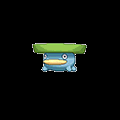

In [42]:
pok_name = "lotad"
pok = dataframe.loc[(dataframe.Name == pok_name)]
tf.keras.utils.load_img(pok.ImgPath.item())

Crearemos un directorio _test_ para que podamos usar correctamente el sistema de predicciones.

In [43]:
shutil.rmtree("test") # Si ya existe el directorio lo borramos para que no haya errores
os.mkdir("test")
os.mkdir("test/test")
shutil.copyfile(pok.ImgPath.item(), "test/test/" + pok.Name.item() + pok.Format.item())

'test/test/lotad.png'

Finalmente predecimos el tipo de pokémon.  

In [44]:
pokemons_test = tf.keras.utils.image_dataset_from_directory(directory="test")
predictions = model.predict(pokemons_test)


Found 1 files belonging to 1 classes.


Primero mostraremos el tipo al que es más probable que pertenezca.  

In [45]:
print("El tipo PREDECIDO es:", cls[(predictions.argmax())])

El tipo PREDECIDO es: Water


Luego mostraremos las probabilidades de cada tipo.  

In [49]:
print("Las probabilidades de que pertenezca a cada tipo son:")
c = 0
for p in predictions[0]:
    print("\t", cls[c], ": %.1f" % (p*100))
    c += 1

Las probabilidades de que pertenezca a cada tipo son:
	 Fire : 0.3
	 Grass : 23.2
	 Water : 76.5


Finalmente mostraremos su tipo real.

In [48]:
print("El tipo REAL es:", pok.Type1.item())

El tipo REAL es: Water
